
# VGG16 Engagement Classifier (Transfer Learning + Fine-tuning)

End-to-end pipeline using **VGG16 + custom head** to classify **engaged vs not_engaged**.

> **What you get**
> - Folder-based loaders for **train / val / test**
> - **Data augmentation**
> - **Train head, then fine-tune last conv block**
> - **EarlyStopping + Checkpoints**
> - **Full evaluation** (accuracy, AUC, F1, confusion matrix, ROC)
> - **Save model** (Keras H5 + SavedModel) and **(optional) TF.js conversion**

**Fill in these three directory paths first:** `TRAIN_DIR`, `VAL_DIR`, `TEST_DIR`.


In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define path to your zip file in Drive
# ⚠️ Change this if your file is in a subfolder
zip_path = "/content/drive/MyDrive/your_dataset.zip"

# Step 3: Unzip the file to a directory in Colab
import zipfile
import os

# Destination to unzip in Colab's file system
unzip_dir = "/content/daisee_dataset"

# Create the destination directory if it doesn't exist
os.makedirs(unzip_dir, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print("✅ Unzipped successfully to:", unzip_dir)

# Step 4: Preview extracted contents
print("\n📂 Top-level files and folders:")
print(os.listdir(unzip_dir))


Mounted at /content/drive
✅ Unzipped successfully to: /content/daisee_dataset

📂 Top-level files and folders:
['your_dataset']


In [2]:

# =========================================
# 0) Imports & config
# =========================================
import os
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# ---- CHANGE THESE ----
TRAIN_DIR = "/content/daisee_dataset/your_dataset/Train"   # e.g. /content/daisee_frames/train
VAL_DIR   = "/content/daisee_dataset/your_dataset/Validation"
TEST_DIR  = "/content/daisee_dataset/your_dataset/Test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
INITIAL_EPOCHS = 5        # train head only
FT_EPOCHS = 10            # fine-tuning 'for the UNFROZEN VGG16 layers'
FREEZE_UP_TO_LAYER = -4   # how many layers from the end of VGG16 to unfreeze (e.g., last conv block)
SEED = 1337

print(tf.__version__)
import os
import random
import shutil
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras import layers

# =========================================
# CONFIG
# =========================================
DATASET_DIR = Path("/content/daisee_dataset/your_dataset")
IMG_SIZE = (224, 224)
TARGET_COUNTS = {
    "Train/engaged": 50000,
    "Train/not_engaged": 50000,
    "Validation/engaged": 10000,
    "Validation/not_engaged": 10000,
    "Test/engaged": 10000,
    "Test/not_engaged": 10000
}

# Define augmentation pipeline
augmentor = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

# =========================================
# FUNCTION: Balance a single directory
# =========================================
def balance_directory(dir_path, target_count):
    img_files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(img_files)
    diff = target_count - current_count

    print(f"[{dir_path}] has {current_count} images. Target: {target_count} => Diff: {diff}")

    # Case 1: Too many — randomly delete extras
    if diff < 0:
        to_delete = random.sample(img_files, -diff)
        for f in to_delete:
            os.remove(os.path.join(dir_path, f))

    # Case 2: Too few — augment existing ones
    elif diff > 0:
        times_to_augment = int(np.ceil(diff / current_count))
        img_files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Refresh
        augmented = 0

        for filename in tqdm(img_files, desc=f"Augmenting {dir_path}"):
            if augmented >= diff:
                break

            img_path = os.path.join(dir_path, filename)
            try:
                image = load_img(img_path, target_size=IMG_SIZE)
                image_array = img_to_array(image)
                image_tensor = tf.expand_dims(image_array, 0)

                for i in range(times_to_augment):
                    if augmented >= diff:
                        break
                    aug_image = augmentor(image_tensor, training=True)
                    aug_image = tf.squeeze(aug_image, axis=0)
                    aug_pil = array_to_img(aug_image)
                    new_name = f"aug_{Path(filename).stem}_{i}_{random.randint(1000,9999)}.jpg"
                    aug_pil.save(os.path.join(dir_path, new_name))
                    augmented += 1
            except Exception as e:
                print(f"Error augmenting {filename}: {e}")

# =========================================
# MAIN LOOP
# =========================================
for relative_path, target in TARGET_COUNTS.items():
    full_path = DATASET_DIR / relative_path
    if full_path.exists():
        balance_directory(full_path, target)
    else:
        print(f"Directory {full_path} does not exist. Skipping.")



2.18.0
[/content/daisee_dataset/your_dataset/Train/engaged] has 94800 images. Target: 50000 => Diff: -44800
[/content/daisee_dataset/your_dataset/Train/not_engaged] has 4700 images. Target: 50000 => Diff: 45300


Augmenting /content/daisee_dataset/your_dataset/Train/not_engaged:  96%|█████████▋| 4530/4700 [24:21<00:54,  3.10it/s]


[/content/daisee_dataset/your_dataset/Validation/engaged] has 27340 images. Target: 10000 => Diff: -17340
[/content/daisee_dataset/your_dataset/Validation/not_engaged] has 3380 images. Target: 10000 => Diff: 6620


Augmenting /content/daisee_dataset/your_dataset/Validation/not_engaged:  98%|█████████▊| 3310/3380 [03:39<00:04, 15.07it/s]


[/content/daisee_dataset/your_dataset/Test/engaged] has 29900 images. Target: 10000 => Diff: -19900
[/content/daisee_dataset/your_dataset/Test/not_engaged] has 1640 images. Target: 10000 => Diff: 8360


Augmenting /content/daisee_dataset/your_dataset/Test/not_engaged:  85%|████████▌ | 1394/1640 [04:30<00:47,  5.16it/s]


In [3]:

# =========================================
# 1) Datasets
# =========================================
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=True,
    seed=SEED
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)



class_names = train_ds.class_names
print("Class names (label 0 -> {}, label 1 -> {}):".format(class_names[0], class_names[1]))
# 0 is engaged and 1 is not_engaged
# Prefetch for speed - prepares the next batch while the GPU is training on the current batch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Class names (label 0 -> engaged, label 1 -> not_engaged):


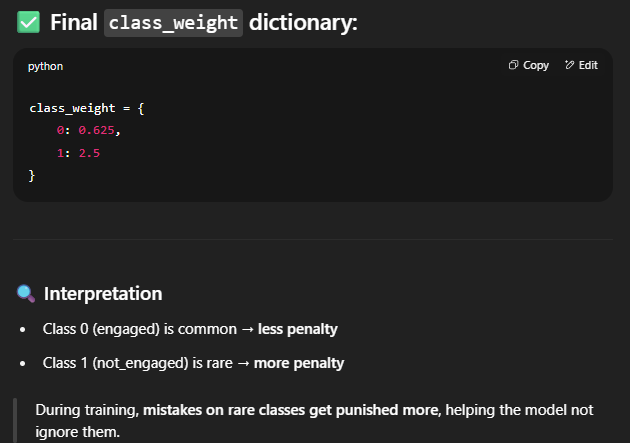

In [4]:

# =========================================
# 2) Optional: class weights (handles imbalance)
# =========================================
def count_images_in_dir(d):
    p = Path(d)
    total = 0
    counts = {}
    for cls in class_names:
        n = len(list((p/cls).glob("*.*")))
        counts[cls] = n
        total += n
    return counts, total

counts, total = count_images_in_dir(TRAIN_DIR)
print("Train counts:", counts)
counts1, total1 = count_images_in_dir(VAL_DIR)
print("Validation counts:", counts1)
counts2, total2 = count_images_in_dir(TEST_DIR)
print("Test counts:", counts2)

# Calculates 'class weights' to penalize the model more if it gets a prediction wrong for the rare class

y_int = np.array([0]*counts[class_names[0]] + [1]*counts[class_names[1]])
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]),
    y=y_int
)
class_weight = {0: class_weights_arr[0], 1: class_weights_arr[1]}
print("Class weights:", class_weight)


Train counts: {'engaged': 50000, 'not_engaged': 50000}
Validation counts: {'engaged': 10000, 'not_engaged': 10000}
Test counts: {'engaged': 10000, 'not_engaged': 10000}
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [5]:

# =========================================
# 3) Data augmentation
# =========================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

# =========================================
# 4) Build model: Frozen VGG16 + custom head
# =========================================
base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,) # FROM (224,224) TO -> (224,224,3)
)
base.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = base(x, training=False)  # keep base frozen
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        257 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:

# =========================================
# 5) Compile & train head
# =========================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"), #higher the better
        tf.keras.metrics.Precision(name="precision"), #higher the better
        tf.keras.metrics.Recall(name="recall") # higher the better
        # all metrics are 0 to 1
    ]
)

ckpt_path = "checkpoints_head/best.weights.h5"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_auc", save_best_only=True, save_weights_only=True, mode="max"),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc", patience=3, mode="max", restore_best_weights=True)
]

history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INITIAL_EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks
)

model.save("/content/drive/MyDrive/engagement_model_final.keras")



Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 605s 191ms/step - accuracy: 0.8843 - auc: 0.9388 - loss: 0.3053 - precision: 0.8975 - recall: 0.8645 - val_accuracy: 0.7747 - val_auc: 0.8601 - val_loss: 0.8516 - val_precision: 0.9748 - val_recall: 0.5640
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 594s 190ms/step - accuracy: 0.9379 - auc: 0.9738 - loss: 0.1759 - precision: 0.9633 - recall: 0.9092 - val_accuracy: 0.7864 - val_auc: 0.8556 - val_loss: 0.6701 - val_precision: 0.9809 - val_recall: 0.5842
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 640s 205ms/step - accuracy: 0.9418 - auc: 0.9765 - loss: 0.1642 - precision: 0.9705 - recall: 0.9102 - val_accuracy: 0.7725 - val_auc: 0.8614 - val_loss: 0.6927 - val_precision: 0.9891 - val_recall: 0.5512
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 636s 190ms/step - accuracy: 0.9448 - auc: 0.9780 - loss: 0.1570 - precision: 0.9745 - recall: 0.9125 - val_accuracy: 0.7785 - val_auc: 0.8546 - val_loss: 0.6763 - val_precision: 0.9751 - val_recall: 0.5715
Epoch 5/5
31

In [7]:

shutil.copytree('/content/daisee_dataset', '/content/drive/MyDrive/daisee_dataset')

# =========================================
# 6) Fine-tune last block
# =========================================
base.trainable = True
for layer in base.layers[:FREEZE_UP_TO_LAYER]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # VERY small LR
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

ckpt_path_ft = "checkpoints_ft/best.weights.h5"
callbacks_ft = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path_ft, monitor="val_auc", save_best_only=True, save_weights_only=True, mode="max"),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc", patience=3, mode="max", restore_best_weights=True)
]

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FT_EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks_ft
)


Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 750s 238ms/step - accuracy: 0.9496 - auc: 0.9809 - loss: 0.1419 - val_accuracy: 0.8155 - val_auc: 0.8691 - val_loss: 0.7214
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 699s 224ms/step - accuracy: 0.9557 - auc: 0.9868 - loss: 0.1195 - val_accuracy: 0.7675 - val_auc: 0.8499 - val_loss: 0.9090
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 787s 238ms/step - accuracy: 0.9588 - auc: 0.9895 - loss: 0.1089 - val_accuracy: 0.7696 - val_auc: 0.8430 - val_loss: 0.9424
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 757s 224ms/step - accuracy: 0.9614 - auc: 0.9914 - loss: 0.1011 - val_accuracy: 0.7775 - val_auc: 0.8359 - val_loss: 1.0885


Test metrics: {'loss': 0.6705493927001953, 'compile_metrics': 0.812250018119812}

Classification report:
               precision    recall  f1-score   support

     engaged     0.7275    0.9984    0.8417     10000
 not_engaged     0.9975    0.6261    0.7693     10000

    accuracy                         0.8123     20000
   macro avg     0.8625    0.8122    0.8055     20000
weighted avg     0.8625    0.8123    0.8055     20000

Confusion matrix:
 [[9984   16]
 [3739 6261]]
ROC AUC: 0.9125383349999999


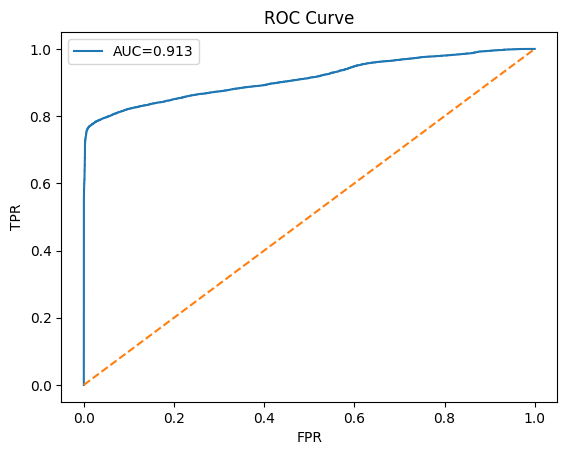

In [8]:

model.save("/content/drive/MyDrive/engagement_model_final.keras")

# =========================================
# 7) Evaluate on test set
# =========================================
test_metrics = model.evaluate(test_ds, verbose=0)
print("Test metrics:", dict(zip(model.metrics_names, test_metrics)))

# Predictions for reports
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0).ravel()
y_pred_proba = np.concatenate([model.predict(x, verbose=0) for x, _ in test_ds], axis=0).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

print("\nClassification report:\n",
      classification_report(y_true, y_pred, target_names=class_names, digits=4))

print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

try:
    test_auc = roc_auc_score(y_true, y_pred_proba)
    print("ROC AUC:", test_auc)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
except ValueError:
    print("ROC AUC not available (probably only one class present in y_true).")


In [ ]:
import os
os.makedirs("saved", exist_ok=True)
# Save your model to Drive in HDF5 format
model.save('/content/drive/MyDrive/engagement_classifier.h5')


# Save for Keras use (optional)
model.save("saved/engagement_vgg16_finetuned.keras")  # Recommended for reloading in Python

# Save for TensorFlow.js (must use SavedModel format!)

print("Model saved!")


In [12]:
from tensorflow.keras.models import load_model

model = load_model('/content/saved/engagement_vgg16_finetuned.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
from google.colab import files
uploaded = files.upload()
video_path = list(uploaded.keys())[0]


Saving video22.mp4 to video22.mp4


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[1.]]


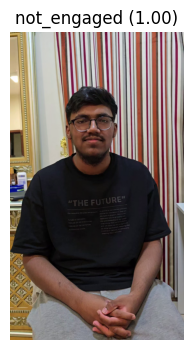

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[1.]]


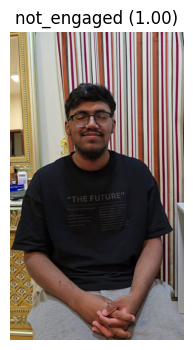

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[[1.]]


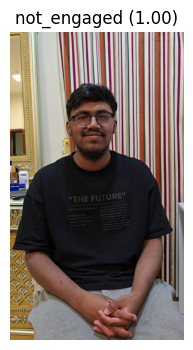

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[1.]]


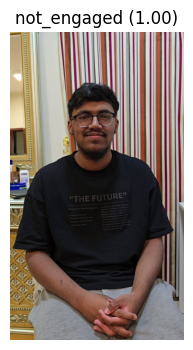

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[1.]]


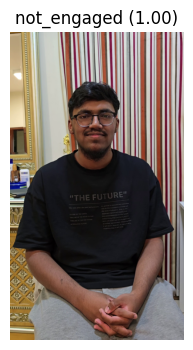

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[1.]]


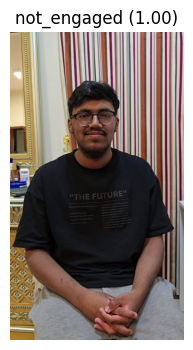

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[1.]]


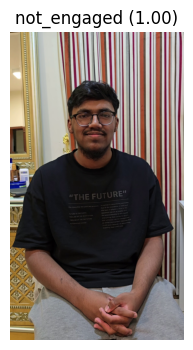

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[1.]]


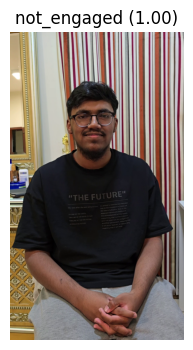

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[1.]]


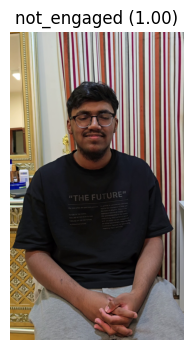

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[1.]]


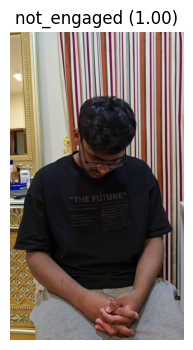

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[1.]]


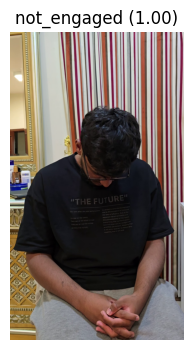

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[1.]]


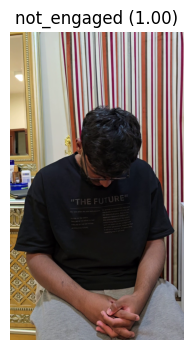

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[1.]]


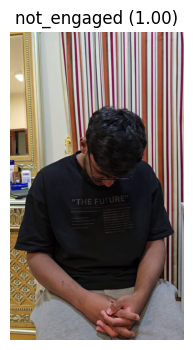

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[1.]]


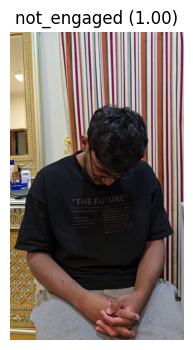

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
[[1.]]


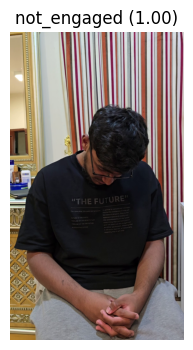

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[[1.]]


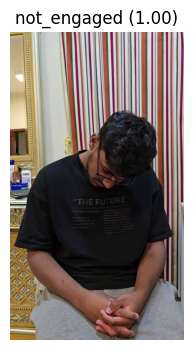

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
[[1.]]


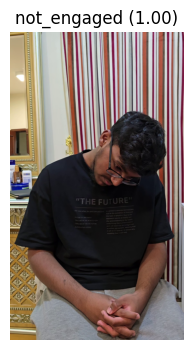

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[[1.]]


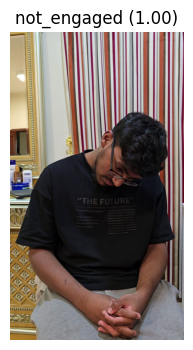

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[1.]]


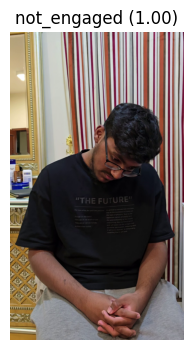

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[1.]]


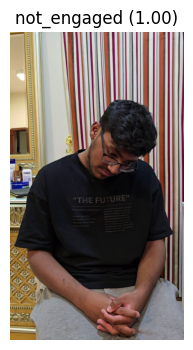

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
[[1.]]


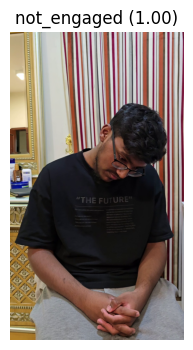

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[1.]]


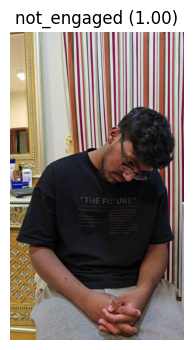

✅ Done! Displayed 22 frames.


In [21]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Load model
class_names = ['engaged', 'not_engaged']

# Open the video
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_interval = int(fps // 2)  # 2 frames per second

frame_count = 0
display_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % frame_interval == 0:
        # Preprocess frame
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (224, 224))
        img_array = img_resized.astype("float32") / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        prob = model.predict(img_array)[0][0]
        label = class_names[int(prob > 0.5)]

        # Display
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{label} ({prob:.2f})")
        plt.show()

        display_count += 1

    frame_count += 1

cap.release()
print(f" Done! Displayed {display_count} frames.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: not_engaged (Confidence: 1.00)
